In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics.cluster import adjusted_rand_score

# Ensure plots show inline
%matplotlib inline
sns.set_style("whitegrid")

In [10]:
## Load Data
returns_file = '../data/stock_returns.csv'
econ_file = '../data/economic_indicators.csv'

df_returns = pd.read_csv(returns_file, index_col=0, parse_dates=True)
df_econ = pd.read_csv(econ_file, index_col=0, parse_dates=True)

print("Stock returns shape:", df_returns.shape)
print("Economic indicators shape:", df_econ.shape)

# check for NaNs
print("Number of NaNs in returns:", df_returns.isna().sum().sum())
print("Number of NaNs in econ:", df_econ.isna().sum().sum())

Stock returns shape: (13285, 100)
Economic indicators shape: (612, 3)
Number of NaNs in returns: 0
Number of NaNs in econ: 0


In [11]:
## Resample returns to monthly frequency
# Compute correlation matrices at month end, using a rolling window on daily data.
window = 60  # days
min_periods = 30
dates = df_returns.resample('M').last().index
stock_list = df_returns.columns

corr_matrices = {}
for current_date in dates:
    end_date = current_date
    start_date = end_date - pd.tseries.offsets.BDay(window)
    window_data = df_returns.loc[start_date:end_date]
    if len(window_data) >= min_periods:
        corr_mat = window_data.corr()
        corr_matrices[current_date] = corr_mat
    else:
        corr_matrices[current_date] = None

print("Computed correlation matrices for", len([d for d in corr_matrices if corr_matrices[d] is not None]), "months.")

/var/folders/mr/80cp3t0j0h9569mb6_y3cg5c0000gn/T/ipykernel_9201/1399513775.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = df_returns.resample('M').last().index


Computed correlation matrices for 610 months.


In [12]:
## Dynamic Threshold Selection
threshold_percentile = 0.9

def dynamic_threshold(corr_matrix, percentile=0.9):
    tri_idx = np.triu_indices_from(corr_matrix, k=1)
    upper_vals = corr_matrix.values[tri_idx]
    thr = np.percentile(upper_vals, percentile*100)
    return thr

month_thresholds = {}
filtered_corr_matrices = {}

for d, cmat in corr_matrices.items():
    if cmat is not None:
        thr = dynamic_threshold(cmat, threshold_percentile)
        month_thresholds[d] = thr
        fcmat = cmat.copy()
        fcmat[fcmat < thr] = 0
        filtered_corr_matrices[d] = fcmat
    else:
        month_thresholds[d] = None
        filtered_corr_matrices[d] = None

In [13]:
## Hierarchical Clustering
def corr_to_distance(corr_matrix):
    dist = np.sqrt(0.5*(1 - corr_matrix))
    return dist

clusters_by_month = {}

for d, fcmat in filtered_corr_matrices.items():
    if fcmat is not None:
        dist_mat = corr_to_distance(fcmat)
        tri_idx = np.triu_indices(len(dist_mat), k=1)
        condensed_dist = dist_mat.values[tri_idx]

        # Hierarchical clustering
        Z = linkage(condensed_dist, method='average')

        # Cutoff, e.g., max 10 clusters
        max_clusters = 10
        cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
        clusters_by_month[d] = cluster_labels
    else:
        clusters_by_month[d] = None

sample_date = next(iter(clusters_by_month))
print("Sample clusters for", sample_date, ":", clusters_by_month[sample_date])

Sample clusters for 1960-02-29 00:00:00 : None


In [14]:
## Cluster Stability
# Measure stability by comparing cluster assignments month-to-month using adjusted Rand index.
months_sorted = sorted([d for d in clusters_by_month if clusters_by_month[d] is not None])
stability_scores = []
for i in range(1, len(months_sorted)):
    prev_labels = clusters_by_month[months_sorted[i-1]]
    curr_labels = clusters_by_month[months_sorted[i]]
    if (prev_labels is not None) and (curr_labels is not None):
        score = adjusted_rand_score(prev_labels, curr_labels)
        stability_scores.append((months_sorted[i], score))

df_stability = pd.DataFrame(stability_scores, columns=['date', 'stability_score']).set_index('date')

# join with economic indicators (monthly)
df_combined = df_stability.join(df_econ, how='inner')

print("Stability and economic indicators combined:")
display(df_combined.head())

# correlations with economic indicators
correlations_to_econ = df_combined.corr()
print("Correlation of stability_score with economic indicators:")
print(correlations_to_econ['stability_score'])

Stability and economic indicators combined:


,stability_score,household_income,cpi,government_debt
1960-04-30,0.281445,49887.099958,100.300251,1.009328e+12
1960-05-31,0.597678,50108.714627,100.119371,1.012082e+12
1960-06-30,0.038942,50076.112630,100.324347,1.017812e+12
1960-07-31,-0.013165,50225.750347,100.421541,1.015405e+12
1960-08-31,-0.010530,50677.790197,99.317909,1.009087e+12


Correlation of stability_score with economic indicators:
stability_score     1.000000
household_income    0.010757
cpi                 0.014901
government_debt     0.007893
Name: stability_score, dtype: float64


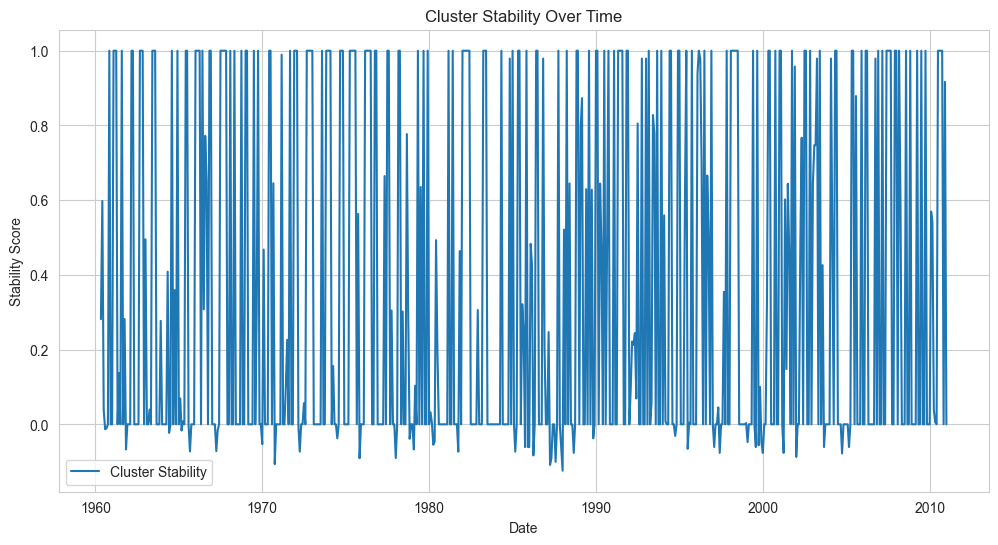

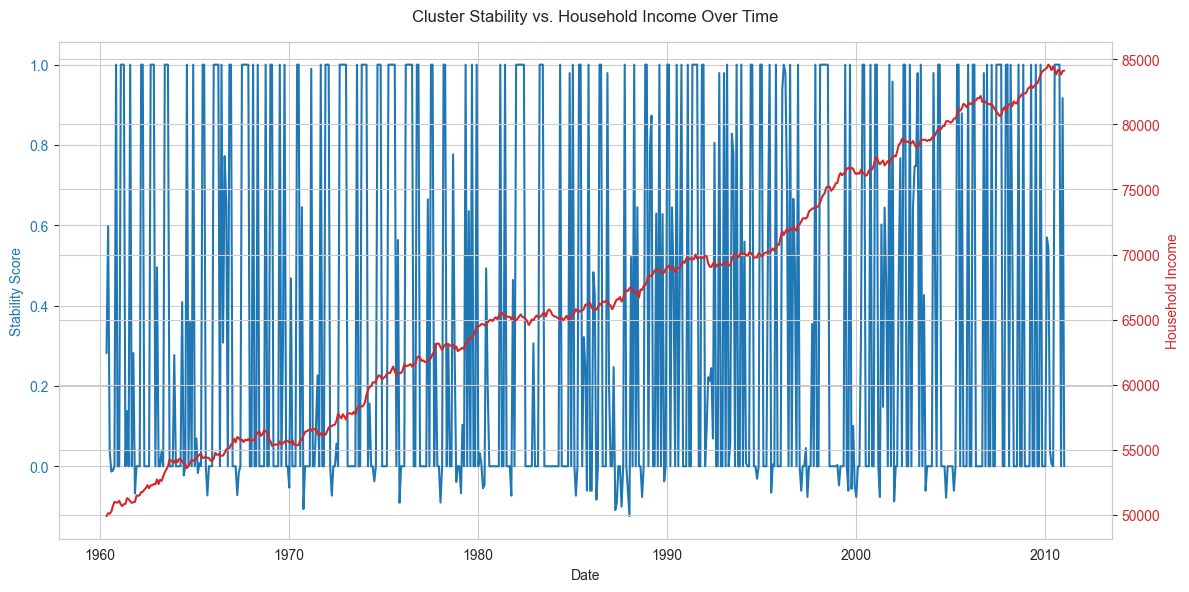

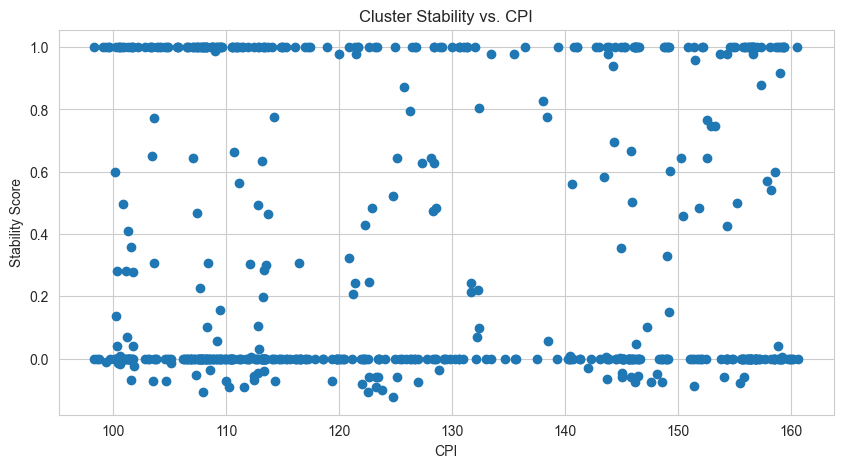

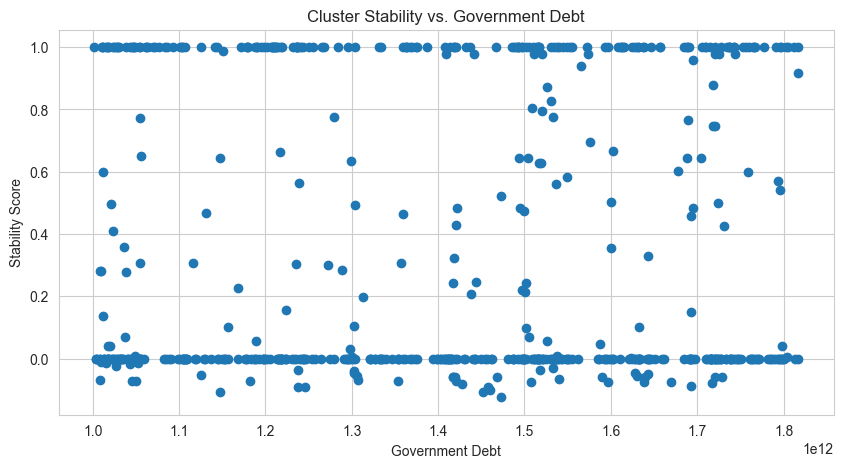

In [19]:
## Visualizations

# Cluster stability over time
plt.figure(figsize=(12,6))
plt.plot(df_combined.index, df_combined['stability_score'], label='Cluster Stability')
plt.title("Cluster Stability Over Time")
plt.xlabel("Date")
plt.ylabel("Stability Score")
plt.legend()
plt.savefig('../visualizations/cluster_stability.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot stability vs. household_income
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_combined.index, df_combined['stability_score'], color='tab:blue', label='Stability Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stability Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_combined.index, df_combined['household_income'], color='tab:red', label='Household Income')
ax2.set_ylabel('Household Income', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle("Cluster Stability vs. Household Income Over Time")
fig.tight_layout()
plt.savefig('../visualizations/cluster_stability_vs_household_income.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter plot stability vs. CPI
plt.figure(figsize=(10,5))
plt.scatter(df_combined['cpi'], df_combined['stability_score'])
plt.title("Cluster Stability vs. CPI")
plt.xlabel("CPI")
plt.ylabel("Stability Score")
plt.savefig('../visualizations/cluster_stability_vs_cpi.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter plot stability vs. Government Debt
plt.figure(figsize=(10,5))
plt.scatter(df_combined['government_debt'], df_combined['stability_score'])
plt.title("Cluster Stability vs. Government Debt")
plt.xlabel("Government Debt")
plt.ylabel("Stability Score")
plt.savefig('../visualizations/cluster_stability_vs_government_debt.png', dpi=300, bbox_inches='tight')
plt.show()